# 2D Steady-State Heat Conduction Equation with Source 

Consider the steady-state heat conduction equation with a heat source, q. The source/forcing term  drives the solution to its steady state.

$$
\begin{equation}
\alpha\nabla^2 T = q
\end{equation}
$$


$$
\implies \frac{\partial ^2 T}{\partial x^2} + \frac{\partial ^2 T}{\partial y^2} = \frac{1}{\alpha}q
$$

In discretized form, this looks almost the same as the Laplace Equation, except for the source term on the right-hand side:

$$
\frac{T_{i,j+1}^k - 2T_{i,j}^k + T_{i,j-1}^k}{\Delta x^2} + \frac{T_{i+1,j}^k - 2T_{i,j}^k + T_{i-1,j}^k}{\Delta y^2} =  \frac{1}{\alpha}q
$$

**Note**: that $k$ here is not a time index, but an index indicating the current iteration number, when perfoming relaxation schemes.

Let us suppose that the analytical solution to the equation is:

$$
T(x,y) = \frac{\sin(2\pi x)\sin(2\pi y)}{\alpha} \\
\implies  \nabla^2T(x,y) = \frac{-8\pi^2\sin(2\pi x)\sin(2\pi y)}{\alpha}
$$

You will use the following inputs to your code.

* $L_x, L_y = 1,1 \;$
* $\alpha = 10 \;$
* $nx, ny = 62,62$ (including the 2 ghost cells)

Initial condition:
$$\begin{equation} T(x,y,t=0) = 0 \; \end{equation} $$

Boundary conditions for T:
$  \; $ 

$$\begin{equation} T(x=0,y,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$ 

$$\begin{equation} T(x=L,y,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$ 

$$\begin{equation} T(x,y=0,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$ 

$$\begin{equation} T(x,y=L,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$


<img src="grid_figure.png" width="700">

To follow the above figure as well as the indexing in the above discretized equations, we firstly need to decide on the axes-orientation and secondly to meet the Python axes-direction. In order to keep physical orientation in our computational grid (again that's just a personal preference) we initialise our variable as **[ny, nx]** and in order to meet Python axes-direction we flip the top (north) and bottom (south) BC, by maintaining the rest as they are.

## Successive Over-Relaxation method
$$
T_{i,j}^{k+1}= (1-\omega)T_{i,j}^{k} + \omega\frac{(T_{i+1,j}^{k}+T_{i-1,j}^{k+1})\Delta x^2+(T_{i,j+1}^{k}+T_{i,j-1}^{k+1})\Delta y^2-\frac{1}{\alpha}q_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
$$

## Conjugate-Gradient method
We will work following a vector-form concept and update $\bf T$ according to:

$$
\begin{equation}
{\bf T}^{k+1}={\bf T}^k + \alpha {\bf d}^k
\end{equation}
$$

To start the method we set ${\bf d}^0 = {\bf r}^0$ for the first step only. Then, we follow the steps below:

Calculate ${\bf d}^0 = {\bf r}^0$ (just  once), then

1. Calculate $\alpha = \frac{{\bf r}^k \cdot {\bf r}^k}{A{\bf d}^k \cdot {\bf d}^k}$
2. Update ${\bf T}^{k+1}$
3. Calculate ${\bf r}^{k+1} = {\bf r}^k - \alpha A {\bf d}^k$ $\ \ \ \ $(see <a href='#references'>Shewchuk (1994)</a>)
4. Calculate $\beta = \frac{{\bf r}^{k+1} \cdot {\bf r}^{k+1}}{{\bf r}^k \cdot {\bf r}^k}$
5. Calculate ${\bf d}^{k+1}={\bf r}^{k+1}+\beta{\bf d}^{k}$
6. Repeat!

In [1]:
#---------- Import libraries ----------

import numpy
import time
import matplotlib.pyplot as plt
from scipy import sparse
from helper import plot_3d

np = numpy

In [2]:
#---------- Define Functions ----------

def get_ic(nx,ny):
    
    """
    
    It sets the IC for the var
    
    nx : integer
         number of points in x-direction
              
    ny : integer
         number of points in y-direction
    
    """
    
    var = numpy.zeros((ny,nx))
    
    return var


def update_bc(var):
    
    """
    
    It updates the BCs for the var
    
    var : numpy.ndarray
          solution of the PDE at a given step
    
    """
    
    # BC West & East
    var[:,0]  = 0
    var[:,-1] = 0

    # BC South & North
    var[0,:]  = 0
    var[-1,:] = 0
    
    return var


def get_source(var,X,Y):
    
    """
    
    It computes the source/RHS term of the equation
    
    var : numpy.ndarray
          solution of the PDE at a given step
          
    X   : array
          2D x-grid
         
    Y   : array
          2D y-grid
    
    """

    source = - 8 * (numpy.pi ** 2) * numpy.sin(2 * numpy.pi * X) * numpy.sin(2 * numpy.pi * Y)
    
    return source


def get_source_challenging(var,X,Y):
    
    """
    
    It computes the source/RHS term of the equation
    
    var : numpy.ndarray
          solution of the PDE at a given step
          
    X   : array
          2D x-grid
         
    Y   : array
          2D y-grid
    
    """

    source = (- 8 * (numpy.pi ** 2) * numpy.sin(2 * numpy.pi * X) * numpy.cos(2 * numpy.pi * Y) +
              - 8 * (numpy.pi ** 2) * numpy.cos(2 * numpy.pi * X) * numpy.sin(2 * numpy.pi * Y))
    
    return source


def l2_norm(var,var_ref):
    
    """
    
    It computes and returns the normalised L2-norm of the difference
    between a solution var and a reference solution var_ref

    var     : numpy.ndarray
              solution of the PDE at a given step
        
    var_ref : numpy.ndarray
              reference solution of the PDE at a given step

    """
    
    l2_norm = numpy.sqrt(numpy.sum((var - var_ref) ** 2)) / (nx * ny)
    
    return l2_norm


def sor(var,X,Y,dx,dy,alpha,maxiter=3000,tolerance=1e-9):
    
    """
    
    It solves thes 2D Poisson equation using the Successive Over-Relaxation method
    
    var       : numpy.ndarray
                solution of the PDE at a given step
                
    X         : array
                2D x-grid
         
    Y         : array
                2D y-grid
    
    dx        : float
                space-step of numerical method in x-direction
         
    dy        : float
                space-step of numerical method in y-direction
    
    alpha     : float
                diffusivity constant
          
    maxiter   : integer
                maximum number of corrcetion cycles/iterations repeated
              
    tolerance : float
                maximum accepted error in order to exit loop
    
    """

    # Get Source/RHS
    q   = get_source(var,X,Y)
    rhs = q / alpha

    # Initialise variables for the loop
    iters          = 0
    difference     = tolerance + 1.0
    difference_str = numpy.zeros(maxiter)
    iters_str      = numpy.zeros(maxiter)
    
    # Define relaxation factor
    omega          = 1.5

    start = time.time()
    
    # Solve the linear system
    while (iters < maxiter and difference > tolerance):
        
        # Previous solution
        var_old = numpy.copy(var)
        
        for i in range (1,ny-1):     # Note : Only wok in the interior points
            for j in range (1,nx-1):
                # Calcualte new solution
                var[i,j] = ((1 - omega) * var[i,j] +
                           omega * ((var[i,j+1] + var[i,j-1]) * dy ** 2 + 
                                    (var[i+1,j] + var[i-1,j]) * dx ** 2 -
                           (rhs[i,j] * dx ** 2 * dy ** 2)) /
                           (2 * (dx ** 2 + dy ** 2)))

        # Update BC
        var = update_bc(var)

        # Compute difference as a normalised L2-norm
        difference = l2_norm(var,var_old)
        #difference = (numpy.sqrt(numpy.sum((var - var_old) ** 2) / (nx * ny)))

        # Update iteration variable
        iters += 1
        
        # Track loop quantities
        iters_str[iters - 1]      = iters
        difference_str[iters - 1] = difference

    end = time.time()
    duration = end-start

    # Print statistics
    print('Successive Over-Relaxation method:')
    if iters == maxiter:
        print('Warning: maximum number of iterations reached!')
    print('~ Number of iterations: {}'.format(iters))
    print('~ Final difference: {}'.format(difference))
    print('~ Time: {0:.4f}'.format(duration),'sec')

    return var, duration, iters_str, difference_str


def laplacian_operator(var, dx, dy):
    
    """
    
    It computes the Laplacian of a vector

    var : numpy.ndarray
          solution of the PDE at a given step
          
    dx  : float
          space-step of numerical method in x-direction
         
    dy  : float
          space-step of numerical method in y-direction
                
    """
    
    laplacian = ( 1 / dx**2 * (var[1:-1, 2:] + var[1:-1, :-2]) + 
                  1 / dy**2 * (var[2:, 1:-1] + var[:-2, 1:-1]) -
                  4 * (1/dx**2) * var[1:-1, 1:-1])    
    
    return laplacian


def cg(var,X,Y,dx,dy,nx,ny,alpha,maxiter=3000,tolerance=1e-9):
    
    """
    
    Solves the 2D Poisson equation for a given source/RHS using the method 
    of conjugate gradients. The exit criterion of the solver is based on 
    the relative L2-norm of the solution difference betweentwo consecutive 
    iterations.

    var       : numpy.ndarray
                solution of the PDE at a given step

    X         : array
                2D x-grid
         
    Y         : array
                2D y-grid
    
    dx        : float
                space-step of numerical method in x-direction
         
    dy        : float
                space-step of numerical method in y-direction
                
    nx        : integer
                number of points in x-direction
              
    ny        : integer
                number of points in y-direction
    
    alpha     : float
                diffusivity constant
                
    dx        : float
                space-step of numerical method in x-direction
         
    dy        : float
                space-step of numerical method in y-direction
               
    maxiter   : integer
                maximum number of corrcetion cycles/iterations repeated
              
    tolerance : float
                maximum accepted error in order to exit loop
                
    """
    
    # Get Source/RHS
    q   = get_source(var,X,Y)
    rhs = q / alpha

    # Compute the initial residual
    r = numpy.zeros_like(var)
    r[1:-1,1:-1] = rhs[1:-1,1:-1] - laplacian_operator(var,dx,dy)
    
    # Initialise variables for the loop
    Ad             = numpy.zeros_like(var) # to store the mat-vec multiplication
    difference     = tolerance + 1         # initial difference
    iters          = 0                     # iteration index
    difference_str = numpy.zeros(maxiter)  # store difference
    iters_str      = numpy.zeros(maxiter)  # store iters
    
    # Define the initial search direction to be the residual
    d = r.copy()
    
    start = time.time()

    while (difference > tolerance and iters < maxiter):
        
        # Temporarily store current solution 
        vark = var.copy()
        rk   = r.copy()
        
        # Compute the Laplacian of the search direction
        Ad[1:-1,1:-1] = laplacian_operator(d, dx, dy)
        
        # Compute the step size
        alpha = np.sum(r*r) / np.sum(Ad * d)
        
        # Update the solution
        var = vark + alpha*d
        
        # Update the residual
        r = rk - alpha*Ad
        
        # Update the search direction
        beta = np.sum(r*r) / np.sum(rk * rk)
        d    = r + beta*d
        
        # Compute the normalised L2-norm of the difference
        difference = l2_norm(var, vark)
        
        # Update iteration variable
        iters += 1
        
        # Track loop quantities
        iters_str[iters - 1]      = iters
        difference_str[iters - 1] = difference
        
    end      = time.time()
    duration = end-start
     
    # Update BC
    var = update_bc(var)
    
    # Print statistics
    print('Conjugate-Gradient method:')
    if iters == maxiter:
        print('Warning: maximum number of iterations reached!')
    print('~ Number of iterations: {}'.format(iters))
    print('~ Final difference: {}'.format(difference))
    print('~ Time: {0:.4f}'.format(duration),'sec')
        
    return var, duration, iters_str, difference_str

In [7]:
#---------- Define inputs ----------

alpha          = 10
lx_max, ly_max = 1, 1
nx, ny         = 62, 62
method         = 'CG'

In [8]:
#---------- Solve the equation ----------

# Initialise space arrays
x   = numpy.linspace(0,lx_max,nx)
dx  = x[1] - x[0]
y   = numpy.linspace(0,ly_max,ny)
dy  = y[1] - y[0]
X,Y = numpy.meshgrid(x,y)

# Apply IC
var = get_ic(nx,ny)

# Update BC
var = update_bc(var)

# Solve Poisson Equation
if (method == 'SOR'):
    var, duration_sor, iters_str_sor, difference_str_sor = sor(var,X,Y,dx,dy,alpha,maxiter=3000,tolerance=1e-9)
elif (method == 'CG'):
    var, duration_cg, iters_str_cg, difference_str_cg = cg(var,X,Y,dx,dy,nx,ny,alpha,maxiter=3000,tolerance=1e-9)

Conjugate-Gradient method:
~ Number of iterations: 2
~ Final difference: 1.6538276438296112e-19
~ Time: 0.0017 sec


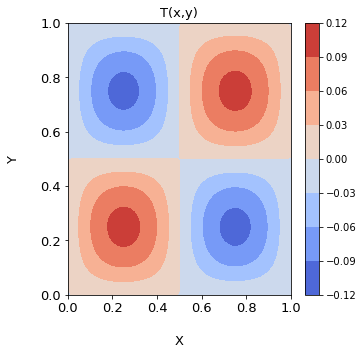

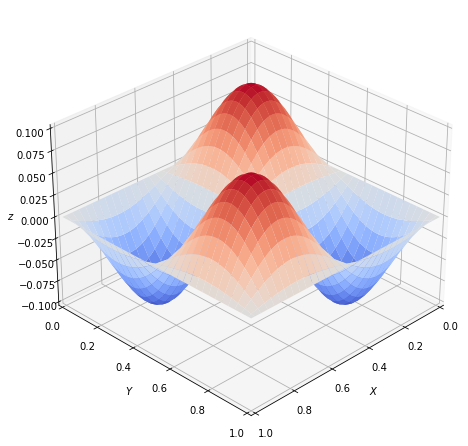

In [9]:
#---------- Plot field in 2D ----------

plt.figure(figsize=(5,5))
size = 13
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.xlabel('X', labelpad=20, fontsize=size)
plt.ylabel('Y', labelpad=20, fontsize=size)
plt.contourf(X,Y,var,cmap='coolwarm')
plt.colorbar()
plt.title('T(x,y)',fontsize=size)
plt.show()

#---------- Plot field in 3D ----------

plot_3d(x, y, var)

NameError: name 'iters_str_cg' is not defined

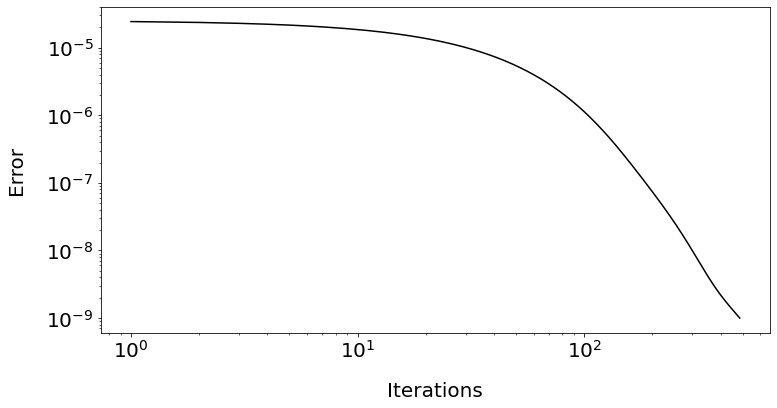

In [6]:
if True:
    
    #---------- Plot Error vs Iterations ----------

    plt.figure(figsize=(12,6))
    size = 20
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    plt.xlabel('Iterations', labelpad=20, fontsize=size)
    plt.ylabel('Error', labelpad=20, fontsize=size)
    plt.loglog(numpy.trim_zeros(iters_str_sor,'b'), numpy.trim_zeros(difference_str_sor,'b'),color='k',
              label='SOR')
    plt.loglog(numpy.trim_zeros(iters_str_cg,'b'), numpy.trim_zeros(difference_str_cg,'b'),color='r',
              label='CG')
    plt.title('Error vs Iterations',fontsize=size)
    plt.legend(loc=1, prop={'size': size})
    plt.show()